# Information Retrieval Exercise 3 Notebook 


This is the template notebook for Exercise 3. The specification for the exercise and the corresponding Exercise 3 Quiz submission instance are available on the Moodle page of the course.

This exercise builds upon Exercise 2, and assumes that you are now familiar with concepts we have introduced in both Exercise 1 and Exercise 2, including:
 - [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - [Pyterrier apply transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html)
 - [PyTerrier pt.Experiment()](https://pyterrier.readthedocs.io/en/latest/experiments.html)


## PyTerrier Setup

First, let's install PyTerrier as usual. 

In [1]:
# !pip install python-terrier lightgbm==2.2.3

Let's start PyTerrier:

In [2]:
import pyterrier as pt
if not pt.started():
    pt.init()

# we require a specific version of LightGBM for this exercise
import lightgbm
assert lightgbm.__version__ == '2.2.3'

/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


PyTerrier 0.6.0 has loaded Terrier 5.5 (built by craigmacdonald on 2021-05-20 13:12)


/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:40: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


In [3]:
# patch location of topics and qrels
def _filter_on_qid_type(self, component, variant):
  import pandas as pd
  if component == "topics":
    data = self.get_topics("all")
  elif component == "qrels":
    data = self.get_qrels("all")
  qid2type = pd.read_csv("http://mirror.ir-datasets.com/79737768b3be1aa07b14691aa54802c5", names=["qid", "type"], sep=" ")
  qid2type["qid"] = qid2type.apply(lambda row: row["qid"].split("-")[1], axis=1)
  rtr = data.merge(qid2type[qid2type["type"] == variant], on=["qid"])
  if len(rtr) == 0:
    raise ValueError("No such topic type '%s'" % variant)
  rtr.drop(columns=['type'], inplace=True)
  return (rtr, "direct")

dataset = pt.get_dataset("trec-wt-2004")
for t in ["np", "td", "hp"]:
  dataset.locations["qrels"][t] = _filter_on_qid_type
  dataset.locations["topics"][t] = _filter_on_qid_type
dataset.locations["qrels"]["all"] = ('04.qrels.web.mixed.txt', "http://www.dcs.gla.ac.uk/~craigm/04.qrels.web.mixed.txt")
dataset.locations["topics_prefixed"]["all"] = ('Web2004.query.stream.trecformat.txt', "http://www.dcs.gla.ac.uk/~craigm/Web2004.query.stream.trecformat.txt", "trec")

## Index, Topics & Qrels for Exercise 3

You will need your login & password credentials from Exercise 2. We will be using again the "50pct" and the "trec-wt-2004" datasets from Exercise 2.


In [4]:
UNAME="2597630w"
PWORD="0729af3d"

from pyterrier.datasets import STANDARD_TERRIER_INDEX_FILES, RemoteDataset

# we will again be using the "50pct" and "trec-wt-2004" datasets
Fiftypct = pt.get_dataset("50pct",  user=UNAME, password=PWORD)
dotgov_topicsqrels = pt.get_dataset("trec-wt-2004")

On the other hand, you will be using a slightly updated index for Exercise 3. It is a bit bigger than the Exercise 2 index, hence it takes about 2-3 minutes to download to Colab. 

We also remove the Ex2 index, if it is found (this will only apply if you are not running on Colab). 

In [5]:
def removeEx2Index():
  import os
  indexdir = os.path.join(Fiftypct.corpus_home, "index")
  if os.path.exists(os.path.join(indexdir, "data.properties")) and not os.path.exists(os.path.join(indexdir, "data-pagerank.oos")):
    #this branch only occurs if the index from IRM Ex2 is found  
    print("WARNING: I have detected and removed an Ex2 index - if you are still working on Ex2, results will be identical, but " +
          "querying time will be a bit longer")
    print("To restore the original Ex2 index, you can delete %s and rerun the Ex2 notebook" % indexdir)
    import shutil
    shutil.rmtree(indexdir)

removeEx2Index()

indexref = Fiftypct.get_index(variant="ex2")
index = pt.IndexFactory.of(indexref)


16:52:29.821 [main] WARN  o.t.s.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 860.9 MiB of memory would be required.


Let's check out the new index. Compared to the index we used for Exercise 2, you can see that this index has `Field Names: [TITLE, ELSE]`, which means that we can provide statistics about how many times each term occurs in the title of each document (the "TITLE" field), vs the rest of the document (the "ELSE" field). Refer to Lecture 8 for more information about fields.

Let's also display the keys in the meta index - this is the metadata that we have stored for each document. You can see that we are storing the "url" and the "body" (content) of the document. These will particularly come in handy for Q2 and Q3 of Exercise 3, respectively.


In [6]:
print(index.getCollectionStatistics())
print("In the meta index: " + str(index.getMetaIndex().getKeys()))

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 2
Number of tokens: 572916194
Field names: [TITLE, ELSE]
Positions:   true

In the meta index: ['docno', 'url', 'title', 'body']


Finally, these are all of the topics and qrels (including the training and validation datasets) that you will need to conduct Exercise 3.

In [7]:
tr_topics = Fiftypct.get_topics("training")
va_topics = Fiftypct.get_topics("validation")

tr_qrels = Fiftypct.get_qrels("training")
va_qrels = Fiftypct.get_qrels("validation")

test_topics = dotgov_topicsqrels.get_topics("hp")
test_qrels = dotgov_topicsqrels.get_qrels("hp")

## Baseline Setup

We introduce here the BatchRetrieve for our baseline. Note that:
 - We are using PL2 as our weighting model to generate the sample (the candidate set of documents to re-rank).
 - We expose more document metadata, namely "url" and "body" for each document retrieved, which you will need to deploy your two new features. 
 - By setting `verbose=True`, we display a progress bar while retrieval executes.

In [8]:
firstpassUB = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)


Let's see the resulting output - you can see that there are now "url" and "body" attributed for each retrieved document. (We also display a progress bar, enabled by the `verbose=True`).

In [9]:
firstpassUB.search("chemical reactions")

BR(PL2): 100%|██████████| 1/1 [00:00<00:00,  1.12q/s]


,qid,docid,docno,url,body,rank,score,query
0,1,513586,G18-38-1767991,http://www.boulder.nist.gov/div838/tar/file03....,NIST - Physical and Chemical Properties Divi...,0,12.755546,chemical reactions
1,1,38544,G01-14-2537005,http://www.labtrain.noaa.gov/shemtfa/chemhaz/n...,. ...,1,11.906524,chemical reactions
2,1,707122,G26-06-3754605,http://www.aps.anl.gov/xfd/tech/safetyenvelope...,APS Experiment Safety Envelope 6: Chemicals ...,2,11.877550,chemical reactions
3,1,382754,G13-59-3981168,http://response.restoration.noaa.gov/chemaids/...,"""); } else { document.write(...",3,11.858475,chemical reactions
4,1,70292,G02-16-2617043,http://www.symp14.nist.gov/PDF/COR04MAY.PDF,A Database of Chemical Reactions Designed to A...,4,11.731490,chemical reactions
...,...,...,...,...,...,...,...,...
995,1,246965,G08-68-4141101,http://en-env.llnl.gov/asd/pinatub.html,The Chemical and Radiative Effects of the Moun...,995,6.290707,chemical reactions
996,1,611136,G22-04-3955177,http://eospso.gsfc.nasa.gov/ftp_docs/Ch7.pdf,Chapter 7 ...,996,6.289822,chemical reactions
997,1,594957,G21-38-0191596,http://www.oit.doe.gov/news/oittimes/wn02/wn02...,search ...,997,6.287830,chemical reactions
998,1,280944,G09-85-3411646,http://www.ig.doe.gov/pdf/chemfina.pdf,INS-O-00-01 I N S P E C T I O N ...,998,6.287759,chemical reactions


# Standard list of features

Let's introduce the list of features we need to deploy a baseline learning-to-rank approach.

In [10]:
pagerankfile = indexref.toString().replace(".properties", "-pagerank.oos")
features = [
    "SAMPLE", #ie PL2
    "WMODEL:SingleFieldModel(BM25,0)", #BM25 title
    "QI:StaticFeature(OIS,%s)" % pagerankfile,
]

stdfeatures = pt.FeaturesBatchRetrieve(index, features, verbose=True)
stage12 = firstpassUB >> stdfeatures

This is our feature set. We will be using FeaturesBatchRetrieve to compute these extra features on the fly. Let's see the output. You can see that there is now a "features" column.

In [11]:
stage12.search("chemical reactions").head(2)

FBR(3 features): 100%|██████████| 1/1 [00:00<00:00,  2.18q/s]


,qid,query,docid,rank,features,docno,score
0,1,chemical reactions,513586,0,"[12.755545561073266, 3.0924078763629836, 0.000...",G18-38-1767991,12.755546
1,1,chemical reactions,38544,1,"[11.90652405775751, 10.789390732195702, 0.0002...",G01-14-2537005,11.906524


Let's look in more detail at the features. It is clear that there are 3 numbers for each document. The first is the PL2 score (1.27555456e+01 == 12.7555), the second is the BM25 score, and the third is the PageRank (a link analysis feature - discussed in more detail in Lecture 10)

In [12]:
stage12.search("chemical reactions").head(1).iloc[0]["features"]

FBR(3 features): 100%|██████████| 1/1 [00:00<00:00,  2.94q/s]


array([1.27555456e+01, 3.09240788e+00, 1.05668333e-04])

# Q1

You now have everyting you need to attempt Q1. You will need to refer to the specification, and to PyTerrier's [learning to rank documentation](https://pyterrier.readthedocs.io/en/latest/ltr.html).

You should use a LightGBM LambdaMART implementation (*not* XGBoost), instantiated using the configuration suggested in the PyTerrier documentation.

Hints:
 - You will need to use the provided separate “training” and “validation” topic sets and qrels to train the learning-to-rank.
 - There is no need to vary the configuration of LightGBM from that in the documentation.

In [13]:
#YOUR SOLUTION
# train LTR
# this configures LightGBM as LambdaMART
lmart_l = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
lmart_l_pipe = stage12 >> pt.ltr.apply_learned_model(lmart_l, form="ltr")
lmart_l_pipe.fit(tr_topics, tr_qrels, va_topics, va_qrels)

# compare LTR with PL2 using MAP / P@5
pt.Experiment(
    [firstpassUB, lmart_l_pipe],
    test_topics,
    test_qrels,
    ["map", "P_5"],
    round=4, baseline=0,
    names=["PL2 Baseline", "LambdaMART (LightGBM)" ]
)

FBR(3 features): 100%|██████████| 54/54 [00:19<00:00,  2.81q/s]
/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.277778
[2]	valid_0's ndcg@1: 0.351852
[3]	valid_0's ndcg@1: 0.351852
[4]	valid_0's ndcg@1: 0.388889
[5]	valid_0's ndcg@1: 0.388889
[6]	valid_0's ndcg@1: 0.407407
[7]	valid_0's ndcg@1: 0.407407
[8]	valid_0's ndcg@1: 0.407407
[9]	valid_0's ndcg@1: 0.388889
[10]	valid_0's ndcg@1: 0.388889


FBR(3 features): 100%|██████████| 75/75 [00:26<00:00,  2.83q/s]


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2 Baseline,0.2251,0.0693,NaN,NaN,NaN,NaN,NaN,NaN
1,LambdaMART (LightGBM),0.4107,0.1147,45.0,15.0,0.000097,22.0,6.0,0.001787


# Q2 - URL Length Features

In this block, please provide your code for Q2 concerning your two URL Length features, namely URL Length by counting slashes (URL-slashes) and URL Length through using the type of the URL (URL-type). There are different possible URL length features that you could implement (see specification). Do carefully read and follow the Exercise 3 specification before starting the implementation of the features.

Some hints:

 - You will need to use a [pt.apply function](https://pyterrier.readthedocs.io/en/latest/apply.html) for computing your URL feature(s). The dataframe of results obtained from the upstream transformer has all of the information you need.

 - You can use a `**` operator for combining feature sets.

 - Refer to the PyTerrier learning to rank documentation  concerning `features_importances_` for obtaining feature importances.

 - You may wish to refer to Python's [`urlparse()`](https://docs.python.org/3/library/urllib.parse.html) function.

 - Use Python assertions to test that your feature implmentation(s) give the expected results. 


## Q2 (a) URL-Slashes Feature

In this block you should define your URL-Slashes feature, and test it. 

In [14]:
#YOUR SOLUTION
from urllib.parse import urlparse
import numpy as np

def url_slash(row):
    urlpath = urlparse(row['url'])[2]
    slash_count = urlpath.count("/")
    return np.array([slash_count])

url_slash(firstpassUB.search("chemical reaction").iloc[1])[0]

BR(PL2): 100%|██████████| 1/1 [00:00<00:00,  2.73q/s]


3

#### (i) URL-Slashes as a PL2 re-ranker

Now you should evaluate your URL-slashes score by re-ranking PL2. You can now answer the corresponding quiz questions.

In [15]:
#YOUR SOLUTION
pipe_slash = firstpassUB >> pt.apply.doc_score(lambda row: row['score'] - url_slash(row)[0])
pt.Experiment(
    [firstpassUB, pipe_slash],
    test_topics,
    test_qrels,
    ["map", "P_5"],
    round=4, baseline=0,
    names=["PL2 Baseline", "URL-Slash re-ranker"]
)

BR(PL2): 100%|██████████| 75/75 [00:28<00:00,  2.65q/s]


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2 Baseline,0.2251,0.0693,NaN,NaN,NaN,NaN,NaN,NaN
1,URL-Slash re-ranker,0.2848,0.0827,39.0,12.0,0.007463,6.0,2.0,0.132599


In [43]:
pipe_slash.search("cryption")

BR(PL2): 100%|██████████| 1/1 [00:00<00:00, 56.30q/s]


,qid,docid,docno,url,body,score,query,rank
0,1,434993,G15-50-1054100,http://cs-www.ncsl.nist.gov/publications/nistp...,"References[BOCK 88] Peter Bocker, ISDN The Int...",4.382679,cryption,0
2,1,515873,G18-46-1865362,http://socialsecurity.gov/employer/Repfal00.pdf,SSA / I R SSocial SecurityAdministrationIntern...,3.029155,cryption,1
4,1,580563,G20-84-2477732,http://itos.gsfc.nasa.gov/ITOS/remcmd.pdf,Remote Commanding Documentation ...,2.330407,cryption,2
3,1,418765,G14-90-3191980,http://cs-www.ncsl.nist.gov/publications/nistb...,November 1997INTERNET ...,1.695244,cryption,3
5,1,88187,G02-78-3621877,http://cs-www.ncsl.nist.gov/ipsec/papers/aes-d...,Network Working Group ...,0.716963,cryption,4
1,1,494954,G17-68-2584616,http://www.ncs.gov/n2/content/technote/tnv7n4/...,OFFICE OF THE MANAGER ...,0.182290,cryption,5
6,1,457024,G16-34-3764782,http://w3.access.gpo.gov/bxa/ear/txt/734.txt,Part 734--Scope of the Export Administration R...,-0.329457,cryption,6
9,1,567214,G20-36-0506919,http://cs-www.ncsl.nist.gov/staff/jansen/IEEEa...,I N T E L L I G E N T A G E N T SAgents for ...,-1.700625,cryption,7
7,1,424551,G15-11-3633588,http://cs-www.ncsl.nist.gov/publications/nistp...,Special Publication 800-41 Guidelines on Firew...,-2.469812,cryption,8
8,1,427549,G15-22-3805523,http://cs-www.ncsl.nist.gov/publications/nistp...,Security Issues in the Database Language SQLW....,-2.658546,cryption,9


#### (ii) URL-Slashes within an LTR model

Now you should evaluate your URL-slashes score as a feature within a new learned model. You can now answer the corresponding quiz questions.

In [16]:
#YOUR SOLUTION
add_slash_feature = pt.apply.doc_features(url_slash)
pipe_add_slash = firstpassUB >> (stdfeatures ** add_slash_feature)

lmart_l_slash = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
lmart_l_pipe_slash = pipe_add_slash >> pt.ltr.apply_learned_model(lmart_l_slash, form="ltr")
lmart_l_pipe_slash.fit(tr_topics, tr_qrels, va_topics, va_qrels)


FBR(3 features): 100%|██████████| 54/54 [00:18<00:00,  2.87q/s]
/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.277778
[2]	valid_0's ndcg@1: 0.296296
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.351852
[5]	valid_0's ndcg@1: 0.388889
[6]	valid_0's ndcg@1: 0.407407
[7]	valid_0's ndcg@1: 0.407407
[8]	valid_0's ndcg@1: 0.592593
[9]	valid_0's ndcg@1: 0.666667
[10]	valid_0's ndcg@1: 0.685185


In [17]:

pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_slash],
    test_topics,
    test_qrels,
    ["map", "P_5"],
    round=4, baseline=0,
    names=["Baseline(3 features)", "Add URL Slash" ]
)

FBR(3 features): 100%|██████████| 75/75 [00:26<00:00,  2.85q/s]


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,Baseline(3 features),0.4107,0.1147,NaN,NaN,NaN,NaN,NaN,NaN
1,Add URL Slash,0.4577,0.1253,23.0,27.0,0.312466,9.0,6.0,0.349206


In [42]:
lmart_l_slash.feature_importances_

array([166124.06993103, 233412.72677612, 289889.15158081,  42367.00134277])

<BarContainer object of 4 artists>

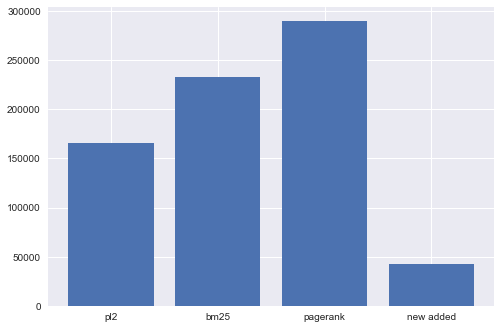

In [18]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

plt.bar(['pl2', 'bm25', 'pagerank', 'new added'], lmart_l_slash.feature_importances_)

## Q2 (b) URL Type Feature

In this block you should define your URL Type feature and test it.

In [19]:
#YOUR SOLUTION
# 0: root, 1: subroot, 2: path, 3: file

def url_type(row):
    urlpath = urlparse(row['url'])[2]
    slash_count = urlpath.count("/")
    if urlpath.endswith("/"):
        if slash_count > 2:
            cate = 2
        else:
            cate = 1
    else:
        if urlpath.endswith("index.html"):
            if slash_count < 2:
                cate = 0
            if slash_count == 2:
                cate = 1
            if slash_count > 2:
                cate = 2
        else:
            if slash_count > 0:
                cate = 3
            else:
                cate = 0
    return np.array([cate])

pipe_test = firstpassUB >> pt.apply.doc_features(url_type)
test_df = pipe_test.transform(test_topics)

BR(PL2): 100%|██████████| 75/75 [00:29<00:00,  2.55q/s]


In [20]:
test_df[test_df['features'] == 0]['url']

60                  http://www.phila.gov
533          http://philadelphia.fbi.gov
954      http://draweb.library.phila.gov
1009          http://usembassy.state.gov
1024                    http://state.gov
                      ...               
73479                http://www.erie.gov
73511          http://www.yorkcounty.gov
73593             http://newyork.fbi.gov
73759          http://schumer.senate.gov
73791       http://www.nyed.uscourts.gov
Name: url, Length: 597, dtype: object

#### (i) URL Type as a PL2 re-ranker

Now you should evaluate your URL type score by re-ranking PL2. You can now answer the corresponding quiz questions.

In [21]:
#YOUR SOLUTION
pipe_type = firstpassUB >> pt.apply.doc_score(lambda row: row['score'] - url_type(row)[0])
pt.Experiment(
    [firstpassUB, pipe_type],
    test_topics,
    test_qrels,
    ["map", "P_5"],
    round=4, baseline=0,
    names=["PL2 Baseline", "URL-Type re-ranker"]
)

BR(PL2): 100%|██████████| 75/75 [00:29<00:00,  2.57q/s]


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,PL2 Baseline,0.2251,0.0693,NaN,NaN,NaN,NaN,NaN,NaN
1,URL-Type re-ranker,0.3632,0.0907,40.0,13.0,0.000022,7.0,0.0,0.010451


In [44]:
pipe_type.search("aaie")

BR(PL2): 100%|██████████| 1/1 [00:00<00:00, 120.06q/s]


,qid,docid,docno,url,body,score,query,rank
0,1,543541,G19-52-0995113,http://sunshine.jpl.nasa.gov/AAIE%20Site%20%c4...,AAIE Photo Album The Jet Propulsion Labo...,14.253916,aaie,0
1,1,88532,G02-80-0379929,http://sunshine.jpl.nasa.gov/1rst%20Tier/Photo...,C ol o Photo Album This section is f...,10.002429,aaie,1
2,1,301428,G10-61-1895354,http://www.cdpr.ca.gov/docs/ipminov/01awards.htm,The 2001 IPM Innovators Awards The 2001 A...,3.478513,aaie,2
3,1,375914,G13-35-3399834,http://www.cdpr.ca.gov/docs/pressrls/9pestinno...,Media Contacts: Glenn Brank 916/445-3974 ...,2.839415,aaie,3
4,1,51341,G01-54-3873617,http://goldmine.cde.ca.gov/calendar/,BODY { margin-left : 0; margin-...,2.442986,aaie,4
5,1,430800,G15-34-2524281,http://www.cde.ca.gov/calendar/,BODY { margin-left : 0; margin-...,2.429759,aaie,5


#### (ii) URL Type within an LTR model

Now you should evaluate your URL type score as a feature within a new learned model. You can now answer the corresponding quiz questions.

In [22]:
#YOUR SOLUTION
add_type_feature = pt.apply.doc_features(url_type)
pipe_add_type = firstpassUB >> (stdfeatures ** add_type_feature)

lmart_l_type = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
lmart_l_pipe_type = pipe_add_type >> pt.ltr.apply_learned_model(lmart_l_type, form="ltr")
lmart_l_pipe_type.fit(tr_topics, tr_qrels, va_topics, va_qrels)

pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_type],
    test_topics,
    test_qrels,
    ["map", "P_5"],
    round=4, baseline=0,
    names=["Baseline(3 features)", "Add URL Type" ]
)

FBR(3 features): 100%|██████████| 54/54 [00:30<00:00,  1.80q/s]
/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.296296
[2]	valid_0's ndcg@1: 0.351852
[3]	valid_0's ndcg@1: 0.388889
[4]	valid_0's ndcg@1: 0.388889
[5]	valid_0's ndcg@1: 0.407407
[6]	valid_0's ndcg@1: 0.407407
[7]	valid_0's ndcg@1: 0.555556
[8]	valid_0's ndcg@1: 0.555556
[9]	valid_0's ndcg@1: 0.555556



BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

[10]	valid_0's ndcg@1: 0.555556


FBR(3 features): 100%|██████████| 75/75 [00:26<00:00,  2.84q/s]


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,Baseline(3 features),0.4107,0.1147,NaN,NaN,NaN,NaN,NaN,NaN
1,Add URL Type,0.4486,0.1253,27.0,19.0,0.302499,9.0,5.0,0.288062


In [41]:
lmart_l_type.feature_importances_

array([134895.78936005, 166788.04193115, 385041.79644775,  42350.96069336])

<BarContainer object of 4 artists>

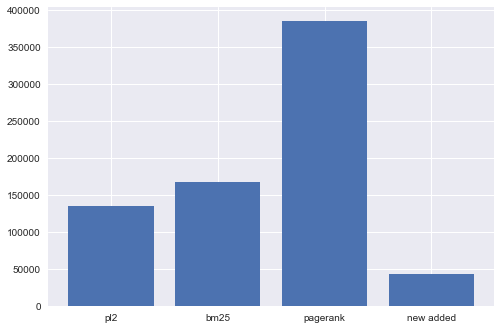

In [23]:
plt.bar(['pl2', 'bm25', 'pagerank', 'new added'], lmart_l_type.feature_importances_)

# Q3 Proximity Search Feature

Now you will implement a new query-dependent feature, using the MinDist() function, as discussed in the specification. Do carefully read the specification before starting the implementation.

Hints:
 - Again, remember to use assertions to test your feature implementations.
 - Refer to the PyTerrier learning to rank documentation concerning features_importances_ for obtaining feature importances

As mentioned in the specification, you should implement a function called avgmindist(), which takes the text of the query and the text of the document, and returns a score for the document, i.e. it must conform to the following Python specification:
```python
def avgmindist(query : str, document : str) -> float
```

NB: There are particular specific requirements for your implementations of MinDist() and avgmindist() that are detailed in the specification.

In [33]:
#YOUR AVGMINDIST IMPLEMENTATION
import string
def avgmindist(query, document):
  #update your implementation here.
    MinDist = 0.0
    dist = {}
    document = "".join(t.lower() for t in document if t not in string.punctuation)
    document = " ".join(t for t in document.split(" ") if t != '')
# create a dictionary with keys == query terms
    for term in query.lower().split(" "):
        dist[term] = []
# set values of dict to corresponding locations in the document
    for loc, term in enumerate(document.split(" ")):
        num_token = loc + 1 #max
        if term in dist:
            dist[term].append(loc)
# retrieve those terms can be found in the document
    pair_list = []
    for key, value in dist.items():
        if value != []:
            pair_list.append(value)
# if no pairs match in a document, set the aggregated value to number of tokens
    if len(pair_list) <= 1:
        MinDist = num_token
# otherwise compute the average MinDist
    else:
        min_pair_dist = []
        for i in range(len(pair_list) - 1):
            pair_dist = []
            for n in pair_list[i]:
                pair_dist.append(min(np.abs(np.array(pair_list[i+1]) - n)) - 1)
            min_pair_dist.append(min(pair_dist))
        MinDist = np.mean(min_pair_dist)
        
    return MinDist

In [38]:
avgmindist("chemical reactions proposal", firstpassUB.search("chemical reactions").iloc[90]['body'])


BR(PL2): 100%|██████████| 1/1 [00:00<00:00,  2.64q/s]


1.0

You should test your impementation yourself, however to allow us to verify your implementation, we have created 9 testcases. Please run `run_test_cases()` and use its responses to answer the relevant quiz questions.



In [37]:
#DO NOT ALTER THIS CELL
TEST_CASES = [
  ('fermilab directory', 45, 567257), #1
  ('webcam', 45, 567257), #2
  ('DOM surface', 384034, 388292), #3
  ('DOM surface', 45, 384034), #4
  ('DOM surface document', 388292, 384034), #5
  ('DOM software AMANDA', 639302, 384034), #6
  ('fermilab directory', 388292, 384034), #7
  ('trigger data', 596532, 639302), #8
  ('underlying hardware', 384034, 333649) #9
]

def run_test_cases():
    docno=0
    body=3
    for i, (query, docid1, docid2) in enumerate(TEST_CASES):
        meta1 = index.getMetaIndex().getAllItems(docid1)
        meta2 = index.getMetaIndex().getAllItems(docid2)
        s1 = avgmindist(query, meta1[body])
        s2 = avgmindist(query, meta2[body])
        if s1 > s2:
            result = meta1[docno]
            cmpD = "%s > %s" % (meta1[docno],meta2[docno])
        elif s2 > s1:
            result = meta2[docno]
            cmpD = "%s > %s" % (meta2[docno],meta1[docno])
        else:
            result = "EQUAL"
            cmpD = "%s == %s" % (meta1[docno],meta2[docno])
        print("TEST CASE %d result %s " % (i+1, result))

run_test_cases()

TEST CASE 1 result G00-00-0478398 
TEST CASE 2 result G20-36-1335992 
TEST CASE 3 result G13-80-1271020 
TEST CASE 4 result G00-00-0478398 
TEST CASE 5 result G13-80-1271020 
TEST CASE 6 result G23-17-3674898 
TEST CASE 7 result G13-80-1271020 
TEST CASE 8 result G23-17-3674898 
TEST CASE 9 result G11-79-2454097 


You should now integrate your avgmindist() function into a new LTR model, and compare its MAP & P@5 performance to the LTR baseline. You can now answer the corresponding quiz questions.

In [39]:
#YOUR SOLUTION
add_dist_feature = pt.apply.doc_features(lambda row: np.array([avgmindist(row['query'], row['body'])]))
pipe_add_dist = firstpassUB >> (stdfeatures ** add_dist_feature)

lmart_l_dist = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
lmart_l_pipe_dist = pipe_add_dist >> pt.ltr.apply_learned_model(lmart_l_dist, form="ltr")
lmart_l_pipe_dist.fit(tr_topics, tr_qrels, va_topics, va_qrels)

pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_dist],
    test_topics,
    test_qrels,
    ["map", "P_5"],
    round=4, baseline=0,
    names=["Baseline(3 features)", "Add AvgMinDist" ]
)

FBR(3 features): 100%|██████████| 54/54 [00:19<00:00,  2.78q/s]
/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.296296
[2]	valid_0's ndcg@1: 0.37037
[3]	valid_0's ndcg@1: 0.388889
[4]	valid_0's ndcg@1: 0.388889
[5]	valid_0's ndcg@1: 0.388889
[6]	valid_0's ndcg@1: 0.37037
[7]	valid_0's ndcg@1: 0.37037
[8]	valid_0's ndcg@1: 0.5
[9]	valid_0's ndcg@1: 0.5
[10]	valid_0's ndcg@1: 0.5


FBR(3 features): 100%|██████████| 75/75 [00:26<00:00,  2.82q/s]


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,Baseline(3 features),0.4107,0.1147,NaN,NaN,NaN,NaN,NaN,NaN
1,Add AvgMinDist,0.4063,0.1173,27.0,23.0,0.90473,8.0,7.0,0.798211


# Q4 A 5-feature Learning-to-Rank Model

You will now experiment with the LightGBM LambdaMART technique where you include both your added features (URL Type and AvgMinDist) along the 3 initial features inc PL2 sample (5 features in total). 

You need to learn a *new* model when using your final selection of 5 features.

Evaluate the performance of your resulting LTR system in comparison to the LTR baseline and answer the quiz questions.

In [40]:
#YOUR SOLUTION
pipe_final = firstpassUB >> (stdfeatures ** add_type_feature ** add_dist_feature)

lmart_l_final = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
lmart_l_pipe_final = pipe_final >> pt.ltr.apply_learned_model(lmart_l_final, form="ltr")
lmart_l_pipe_final.fit(tr_topics, tr_qrels, va_topics, va_qrels)

pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_final],
    test_topics,
    test_qrels,
    ["map", "P_5"],
    round=4, baseline=0,
    names=["Baseline(3 features)", "5 features" ]
)

FBR(3 features): 100%|██████████| 54/54 [00:19<00:00,  2.73q/s]
/Users/siqiwang/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.314815
[2]	valid_0's ndcg@1: 0.407407
[3]	valid_0's ndcg@1: 0.425926
[4]	valid_0's ndcg@1: 0.444444
[5]	valid_0's ndcg@1: 0.444444
[6]	valid_0's ndcg@1: 0.444444
[7]	valid_0's ndcg@1: 0.555556
[8]	valid_0's ndcg@1: 0.574074
[9]	valid_0's ndcg@1: 0.592593
[10]	valid_0's ndcg@1: 0.592593


FBR(3 features): 100%|██████████| 75/75 [00:26<00:00,  2.85q/s]


,name,map,P_5,map +,map -,map p-value,P_5 +,P_5 -,P_5 p-value
0,Baseline(3 features),0.4107,0.1147,NaN,NaN,NaN,NaN,NaN,NaN
1,5 features,0.4565,0.1307,31.0,18.0,0.242447,9.0,3.0,0.083236


In [45]:
pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_type, lmart_l_pipe_dist, lmart_l_pipe_final],
    test_topics,
    test_qrels,
    ["map", "P_1"],
    round=4, baseline=0,
    names=["Baseline(3 features)", "Add URL type", "Add AvgMinDist", "5 features" ]
)

FBR(3 features): 100%|██████████| 75/75 [00:25<00:00,  2.90q/s]


,name,map,P_1,map +,map -,map p-value,P_1 +,P_1 -,P_1 p-value
0,Baseline(3 features),0.4107,0.2933,NaN,NaN,NaN,NaN,NaN,NaN
1,Add URL type,0.4486,0.3200,27.0,19.0,0.302499,8.0,6.0,0.596346
2,Add AvgMinDist,0.4063,0.2667,27.0,23.0,0.904730,6.0,8.0,0.596346
3,5 features,0.4565,0.3333,31.0,18.0,0.242447,9.0,6.0,0.442272


# That's all Folks

**Submission Instructions:** Complete this notebook. All your answers to Exercise 3 must be submitted on the Exercise 3 Quiz instance on Moodle with your completed notebook (showing both your solutions and the results of their executions).


Your answers to the Quiz questions along with your .ipynb notebook file (showing code and outputs) must be submitted by **Friday 18th June 2021, 4:30pm**.